In [609]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.sparse import rand as sprand
import torch
import numpy as np
from torch.autograd import Variable
!pip install numpy==1.16.4
from sklearn.metrics import ndcg_score

    100% |████████████████████████████████| 13.9MB 2.3MB/s eta 0:00:01
  Found existing installation: numpy 1.18.2
    Uninstalling numpy-1.18.2:
      Successfully uninstalled numpy-1.18.2
You are using pip version 18.0, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


ImportError: cannot import name 'ndcg_score'

In [613]:
from sklearn.metrics import ndcg_score

ImportError: cannot import name 'ndcg_score'

In [387]:
#@save
def read_data_ml100k():

    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv('u.data', '\t', names=names,
                       engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

In [388]:
data, num_users, num_items = read_data_ml100k()
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head(5))

number of users: 943, number of items: 1682
matrix sparsity: 0.936953
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


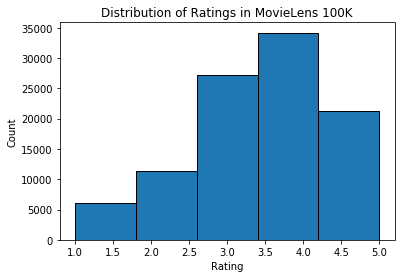

In [389]:

plt.hist(data['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in MovieLens 100K')
plt.show()

In [390]:
def split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

In [391]:
def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter

In [407]:
def read_original_data(filename: str):
    train_dict = dict()
    test_dict = dict()
    train_list = []
    test_list = []
    max_user_id, min_user_id, max_item_id, min_item_id = [10] * 4

    with open(filename, "r", encoding="utf-8") as txt_file:
        for idx, line in enumerate(txt_file):
            # if idx > 50:
            #     break
            user_id, item_id, rating, times = line.strip().split('\t')
            user_id = int(user_id)
            item_id = int(item_id)
            rating = int(rating)

            if user_id > max_user_id:
                max_user_id = user_id
            elif user_id < min_user_id:
                min_user_id = user_id

            if item_id > max_item_id:
                max_item_id = item_id
            elif item_id < min_item_id:
                min_item_id = item_id

            train_dict.setdefault(user_id, []).append((item_id, rating))
            if user_id not in test_dict or times > test_dict[user_id][-1]:
                test_dict[user_id] = (item_id, rating, times)

    for user_id in train_dict:
        for info in train_dict[user_id]:
            item_id = info[0]
            if item_id != test_dict[user_id][0]:
                train_list.append((user_id, item_id, info[1]))
            else:
                test_list.append((user_id, item_id, info[1]))
    return train_list, test_list, [min_user_id, max_user_id], [min_item_id, max_item_id]


def generate_matrix(n_items: int, n_users: int, data: list):
    result = [[0] * n_users] * n_items
    for element in data:
        user_id, item_id, rating = element
        result[item_id - 1][user_id - 1] = rating
    return result


def write_format(target_list: list):
    return "\t".join([str(i) for i in target_list]) + "\n"


def evaluate(test_info: list, predict_matrix: list, filename: str):
    mse = 0
    with open(filename, "w", encoding="utf-8") as txt_file:
        for element in test_info:
            user_id, item_id, rating = element
            predict_value = predict_matrix[item_id - 1][user_id - 1]
            mse += (predict_value - rating) ** 2
            txt_file.write(write_format(target_list=[user_id, item_id, rating, predict_value]))

    mse /= len(test_data)
    mse = np.sqrt(mse)
    print(mse)

# Matrix Factorization

R interaction matrix \n
P: measure the extent of interest the use has in items' corresponding characteristics' \n
R_ui = p_u q_i + b_u + b_i \n
train using l2 loss + ridge regression penality \n
matrix evaluation is RMSE loss \n


In [432]:
class MatrixFactorization(torch.nn.Module):
    
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, 
                                               n_factors
                                               )
        self.item_factors = torch.nn.Embedding(n_items, 
                                               n_factors
                                               
                                               )
        self.user_bias = torch.nn.Embedding(n_users, 1)
        self.item_bias = torch.nn.Embedding(n_items, 1)
        torch.nn.init.normal_(self.user_factors.weight, 0.1)
        torch.nn.init.normal_(self.item_factors.weight, 0.1)
        self.user_bias.weight.data.fill_(0.)
        self.item_bias.weight.data.fill_(0.)
        
    def forward(self, user, item): #squeeze remove dimension equals to 1
        #print((self.user_factors(user) * self.item_factors(item)).sum(1).shape)
        #print(self.user_bias(user).shape)
        return torch.nn.functional.relu((self.user_factors(user) * self.item_factors(item)).sum(1) + self.user_bias(user).squeeze() + self.item_bias(item).squeeze())
    

In [433]:
#generate data
num_users, num_items = 943, 1682
train, test = split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.2)

In [434]:
#evaluation method
def evaluator(model, test):
    rating = torch.FloatTensor([test['rating'].values]).squeeze()
    row = torch.LongTensor([test['user_id'].values]).squeeze()
    col = torch.LongTensor([test['item_id'].values]).squeeze()
    return torch.sqrt(((model(row, col) - rating)**2).sum()/len(rating))
    
    

In [435]:
#training and testing
n_users, n_items = 944, 1683
loss_func = torch.nn.MSELoss()
model = MatrixFactorization(n_users, n_items, n_factors=10)
optimizer = torch.optim.Adam(model.parameters(), 
                            lr= 1e-4, weight_decay = 1e-4 ) # learning rate

l = np.array(list(range(79973)))

for i in range(400):
    random.shuffle(l)
    loss_sum = 0
    for ind in range(0, 79973, 512):
            # Turn data into tensors
            rating = Variable(torch.FloatTensor([train['rating'].iloc[l[ind: ind + 512]].values]).squeeze())
            row = Variable(torch.LongTensor([train['user_id'].iloc[l[ind: ind + 512]].values]).squeeze())
            col = Variable(torch.LongTensor([train['item_id'].iloc[l[ind: ind + 512]].values]).squeeze())

            # Predict and calculate loss
            prediction = model(row, col)
            loss = loss_func(prediction, rating)

            # Backpropagate
            loss.backward()
            loss_sum += loss
            # Update the parameters
            optimizer.step()
    print(evaluator(model, test), loss_sum, evaluator(model, train))

tensor(3.1235, grad_fn=<SqrtBackward>) tensor(1557.1904, grad_fn=<AddBackward0>) tensor(3.1311, grad_fn=<SqrtBackward>)
tensor(3.1038, grad_fn=<SqrtBackward>) tensor(1526.6769, grad_fn=<AddBackward0>) tensor(3.0955, grad_fn=<SqrtBackward>)
tensor(3.0839, grad_fn=<SqrtBackward>) tensor(1489.7649, grad_fn=<AddBackward0>) tensor(3.0595, grad_fn=<SqrtBackward>)
tensor(3.0638, grad_fn=<SqrtBackward>) tensor(1455.4121, grad_fn=<AddBackward0>) tensor(3.0242, grad_fn=<SqrtBackward>)
tensor(3.0437, grad_fn=<SqrtBackward>) tensor(1420.6229, grad_fn=<AddBackward0>) tensor(2.9896, grad_fn=<SqrtBackward>)
tensor(3.0234, grad_fn=<SqrtBackward>) tensor(1388.5786, grad_fn=<AddBackward0>) tensor(2.9557, grad_fn=<SqrtBackward>)
tensor(3.0028, grad_fn=<SqrtBackward>) tensor(1356.2891, grad_fn=<AddBackward0>) tensor(2.9225, grad_fn=<SqrtBackward>)
tensor(2.9820, grad_fn=<SqrtBackward>) tensor(1326.1670, grad_fn=<AddBackward0>) tensor(2.8899, grad_fn=<SqrtBackward>)
tensor(2.9609, grad_fn=<SqrtBackward>) t

tensor(1.3165, grad_fn=<SqrtBackward>) tensor(218.5892, grad_fn=<AddBackward0>) tensor(1.1767, grad_fn=<SqrtBackward>)
tensor(1.3074, grad_fn=<SqrtBackward>) tensor(216.1216, grad_fn=<AddBackward0>) tensor(1.1694, grad_fn=<SqrtBackward>)
tensor(1.2989, grad_fn=<SqrtBackward>) tensor(213.4506, grad_fn=<AddBackward0>) tensor(1.1626, grad_fn=<SqrtBackward>)
tensor(1.2910, grad_fn=<SqrtBackward>) tensor(210.7450, grad_fn=<AddBackward0>) tensor(1.1563, grad_fn=<SqrtBackward>)
tensor(1.2837, grad_fn=<SqrtBackward>) tensor(208.4991, grad_fn=<AddBackward0>) tensor(1.1506, grad_fn=<SqrtBackward>)
tensor(1.2769, grad_fn=<SqrtBackward>) tensor(207.0265, grad_fn=<AddBackward0>) tensor(1.1452, grad_fn=<SqrtBackward>)
tensor(1.2706, grad_fn=<SqrtBackward>) tensor(204.7521, grad_fn=<AddBackward0>) tensor(1.1403, grad_fn=<SqrtBackward>)
tensor(1.2647, grad_fn=<SqrtBackward>) tensor(202.9427, grad_fn=<AddBackward0>) tensor(1.1357, grad_fn=<SqrtBackward>)
tensor(1.2592, grad_fn=<SqrtBackward>) tensor(20

tensor(1.3640, grad_fn=<SqrtBackward>) tensor(238.4856, grad_fn=<AddBackward0>) tensor(1.2352, grad_fn=<SqrtBackward>)
tensor(1.3687, grad_fn=<SqrtBackward>) tensor(239.9287, grad_fn=<AddBackward0>) tensor(1.2385, grad_fn=<SqrtBackward>)
tensor(1.3734, grad_fn=<SqrtBackward>) tensor(240.8320, grad_fn=<AddBackward0>) tensor(1.2418, grad_fn=<SqrtBackward>)
tensor(1.3780, grad_fn=<SqrtBackward>) tensor(242.9009, grad_fn=<AddBackward0>) tensor(1.2450, grad_fn=<SqrtBackward>)
tensor(1.3826, grad_fn=<SqrtBackward>) tensor(243.7868, grad_fn=<AddBackward0>) tensor(1.2482, grad_fn=<SqrtBackward>)
tensor(1.3870, grad_fn=<SqrtBackward>) tensor(245.2923, grad_fn=<AddBackward0>) tensor(1.2512, grad_fn=<SqrtBackward>)
tensor(1.3914, grad_fn=<SqrtBackward>) tensor(246.2611, grad_fn=<AddBackward0>) tensor(1.2541, grad_fn=<SqrtBackward>)
tensor(1.3955, grad_fn=<SqrtBackward>) tensor(247.1018, grad_fn=<AddBackward0>) tensor(1.2568, grad_fn=<SqrtBackward>)
tensor(1.3995, grad_fn=<SqrtBackward>) tensor(24

tensor(1.4364, grad_fn=<SqrtBackward>) tensor(239.6956, grad_fn=<AddBackward0>) tensor(1.2359, grad_fn=<SqrtBackward>)
tensor(1.4359, grad_fn=<SqrtBackward>) tensor(239.3072, grad_fn=<AddBackward0>) tensor(1.2346, grad_fn=<SqrtBackward>)
tensor(1.4353, grad_fn=<SqrtBackward>) tensor(238.5335, grad_fn=<AddBackward0>) tensor(1.2333, grad_fn=<SqrtBackward>)
tensor(1.4345, grad_fn=<SqrtBackward>) tensor(237.9101, grad_fn=<AddBackward0>) tensor(1.2319, grad_fn=<SqrtBackward>)
tensor(1.4336, grad_fn=<SqrtBackward>) tensor(237.5323, grad_fn=<AddBackward0>) tensor(1.2304, grad_fn=<SqrtBackward>)
tensor(1.4325, grad_fn=<SqrtBackward>) tensor(236.8544, grad_fn=<AddBackward0>) tensor(1.2288, grad_fn=<SqrtBackward>)
tensor(1.4312, grad_fn=<SqrtBackward>) tensor(236.6058, grad_fn=<AddBackward0>) tensor(1.2272, grad_fn=<SqrtBackward>)
tensor(1.4299, grad_fn=<SqrtBackward>) tensor(235.8109, grad_fn=<AddBackward0>) tensor(1.2254, grad_fn=<SqrtBackward>)
tensor(1.4283, grad_fn=<SqrtBackward>) tensor(23

tensor(1.3030, grad_fn=<SqrtBackward>) tensor(186.2914, grad_fn=<AddBackward0>) tensor(1.0890, grad_fn=<SqrtBackward>)
tensor(1.3012, grad_fn=<SqrtBackward>) tensor(185.6501, grad_fn=<AddBackward0>) tensor(1.0874, grad_fn=<SqrtBackward>)
tensor(1.2994, grad_fn=<SqrtBackward>) tensor(185.1085, grad_fn=<AddBackward0>) tensor(1.0859, grad_fn=<SqrtBackward>)
tensor(1.2975, grad_fn=<SqrtBackward>) tensor(184.7729, grad_fn=<AddBackward0>) tensor(1.0844, grad_fn=<SqrtBackward>)
tensor(1.2956, grad_fn=<SqrtBackward>) tensor(183.9917, grad_fn=<AddBackward0>) tensor(1.0828, grad_fn=<SqrtBackward>)
tensor(1.2937, grad_fn=<SqrtBackward>) tensor(183.3969, grad_fn=<AddBackward0>) tensor(1.0812, grad_fn=<SqrtBackward>)
tensor(1.2919, grad_fn=<SqrtBackward>) tensor(183.1283, grad_fn=<AddBackward0>) tensor(1.0796, grad_fn=<SqrtBackward>)
tensor(1.2901, grad_fn=<SqrtBackward>) tensor(182.4480, grad_fn=<AddBackward0>) tensor(1.0780, grad_fn=<SqrtBackward>)
tensor(1.2883, grad_fn=<SqrtBackward>) tensor(18

tensor(1.2005, grad_fn=<SqrtBackward>) tensor(154.3607, grad_fn=<AddBackward0>) tensor(0.9913, grad_fn=<SqrtBackward>)
tensor(1.1995, grad_fn=<SqrtBackward>) tensor(154.0081, grad_fn=<AddBackward0>) tensor(0.9900, grad_fn=<SqrtBackward>)
tensor(1.1984, grad_fn=<SqrtBackward>) tensor(153.5785, grad_fn=<AddBackward0>) tensor(0.9888, grad_fn=<SqrtBackward>)
tensor(1.1971, grad_fn=<SqrtBackward>) tensor(153.1530, grad_fn=<AddBackward0>) tensor(0.9876, grad_fn=<SqrtBackward>)
tensor(1.1957, grad_fn=<SqrtBackward>) tensor(152.7793, grad_fn=<AddBackward0>) tensor(0.9864, grad_fn=<SqrtBackward>)
tensor(1.1943, grad_fn=<SqrtBackward>) tensor(152.7220, grad_fn=<AddBackward0>) tensor(0.9853, grad_fn=<SqrtBackward>)
tensor(1.1930, grad_fn=<SqrtBackward>) tensor(152.1174, grad_fn=<AddBackward0>) tensor(0.9841, grad_fn=<SqrtBackward>)
tensor(1.1917, grad_fn=<SqrtBackward>) tensor(151.6809, grad_fn=<AddBackward0>) tensor(0.9829, grad_fn=<SqrtBackward>)
tensor(1.1905, grad_fn=<SqrtBackward>) tensor(15

1. plotting using plotly
2. try different optimizer and see the result
3. wanshan review optimizer after work
4. Why use variable

take away
initialization is very important
train on sparse stuff is very slow

# AutoRec

def: identify CF with an autoencoder architecture and aims to integrate nonlinear transformations into 
    CF on the basis of explicit feedback
structure: an input layer, a hidden layer, and a reconstruction layer. 
    use column/row of the interaction matrix as an input
    

In [397]:
class AutoRec(torch.nn.Module):
    
    def __init__(self, n_users,  n_factors=20, dropout = 0.05):
        super().__init__()
        self.encoder = torch.nn.Linear(n_users, n_factors,  bias=True)
        self.act = torch.nn.Sigmoid()
        self.decoder = torch.nn.Linear(n_factors, n_users, bias=True)
        self.dropout = torch.nn.Dropout(dropout)
        #self.relu = torch.nn.ReLU(inplace=False)
        torch.nn.init.normal_(self.encoder.weight, 0.01)
        torch.nn.init.normal_(self.decoder.weight, 0.01)
        #torch.nn.init.normal_(self.act.weight, 0.01)
        
    def forward(self, user, is_train=1 ): #squeeze remove dimension equals to 1
        hidden = self.dropout(self.act(self.encoder(user)))
        #print(hidden)
        pred = self.decoder(hidden)
#         if autograd.is_training():  # Mask the gradient during training
#             return pred * np.sign(input) 
#         else:
#             
        if is_train == 1:
            pred = pred * np.sign(user)
        return pred

In [398]:
n_users = 943


In [399]:
train_trans = train.pivot_table(index='item_id', columns='user_id').loc[:, 'rating']
train_trans = train_trans.reset_index().drop('item_id', axis = 1).fillna(0)

AttributeError: 'list' object has no attribute 'pivot_table'

In [400]:
test_trans = test.pivot_table(index='item_id', columns='user_id').loc[:, 'rating']
test_trans = test_trans.reset_index().drop('item_id', axis = 1).fillna(0)
for i in range(1, 944):
    if i not in test_trans.columns:
        test_trans[i] = 0
test_trans = test_trans.sort_index(ascending=True, axis=1)

AttributeError: 'list' object has no attribute 'pivot_table'

In [401]:
def evaluate_matrix(test_trans):
    val = (model(Variable(torch.FloatTensor(test_trans.values))).detach().numpy() - test_trans.values)**2
    #print(val)
    sign = np.sign(test_trans.values)

    return np.sqrt(np.sum(val * sign)/np.sum(sign))

关于 loss

loss.backward() computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x. In pseudo-code:

x.grad += dloss/dx
optimizer.step updates the value of x using the gradient x.grad. For example, the SGD optimizer performs:

x += -lr * x.grad
optimizer.zero_grad() clears x.grad for every parameter x in the optimizer. It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.

If you have multiple losses (loss1, loss2) you can sum them and then call backwards once:

loss3 = loss1 + loss2
loss3.backward()

tensor([-1.4953,  1.5546,  1.4921,  0.4234])

对于 istraining 比 在拿到pred 用sign 更快

In [404]:
n_users, n_items = 943, 1683
loss_func = torch.nn.MSELoss()
model = AutoRec(n_users, n_factors=100)
optimizer = torch.optim.Adam(model.parameters(), 
                            lr= 0.002, weight_decay = 1e-5 ) # learning rate

l = np.array(list(range(943)))

test, train = [], []
for i in range(1000):
    random.shuffle(l)
    loss_sum = 0
    model.train()
    for ind in range(0, 943, 256):
            # Turn data into tensors
            rating = Variable(torch.FloatTensor([train_trans.iloc[l[ind: ind + 256]].values]))
            
            # Predict and calculate loss
            prediction = model(rating)
            #method1: register and match
            #prediction.register_hook(lambda grad: grad * torch.FloatTensor(np.sign(train_trans.iloc[l[ind: ind + 256]].values) ))
            
            #method 1 mask after model
            sign = torch.FloatTensor(np.sign(train_trans.iloc[l[ind: ind + 256]].values))
            loss = loss_func(prediction * sign, rating * sign)

            #mask in the model
            loss = loss_func(prediction , rating )
            
                
            # Backpropagate
            loss.backward()
            loss_sum += loss
            # Update the parameters
            optimizer.step()
    if i % 10 == 0:
        model.eval()
        test.append(evaluate_matrix(test_trans))
        train.append(evaluate_matrix(train_trans))
        print(evaluate_matrix(test_trans), loss_sum, evaluate_matrix(train_trans))

14.683326210634394 tensor(88.4654, grad_fn=<AddBackward0>) 14.797309719910269
12.475249047027127 tensor(42.4289, grad_fn=<AddBackward0>) 11.199343685069225
12.276483609264808 tensor(33.4972, grad_fn=<AddBackward0>) 9.896485949835231
11.022524319563313 tensor(26.4467, grad_fn=<AddBackward0>) 8.9694888470072
9.484044306429725 tensor(21.3801, grad_fn=<AddBackward0>) 7.95752944927133
7.964184591698304 tensor(15.8457, grad_fn=<AddBackward0>) 6.886913289981216
6.843455180860399 tensor(11.9608, grad_fn=<AddBackward0>) 5.950099806256724
5.90475264609777 tensor(8.2655, grad_fn=<AddBackward0>) 4.985017883117118
5.147927477276663 tensor(6.0361, grad_fn=<AddBackward0>) 4.294854373047684
4.546448059622635 tensor(4.8081, grad_fn=<AddBackward0>) 3.8006649904748198
4.0556940215884945 tensor(3.7723, grad_fn=<AddBackward0>) 3.3880557759090526
3.641942445492659 tensor(3.1096, grad_fn=<AddBackward0>) 3.0642911719193533
3.3031199671144416 tensor(2.5150, grad_fn=<AddBackward0>) 2.7761436186668624
3.01896093

In [406]:
test

[14.683326210634394,
 12.475249047027127,
 12.276483609264808,
 11.022524319563313,
 9.484044306429725,
 7.964184591698304,
 6.843455180860399,
 5.90475264609777,
 5.147927477276663,
 4.546448059622635,
 4.0556940215884945,
 3.641942445492659,
 3.3031199671144416,
 3.0189609395938124,
 2.771066959438655,
 2.572145617036963,
 2.410551102895394,
 2.2946238418713523,
 2.215802969735319,
 2.167462342895875,
 2.1404472969946964,
 2.153221126055412,
 2.1789268210186488,
 2.197816799358841,
 2.198970288729983,
 2.1757496533662484,
 2.138508610381834,
 2.0800196376314926,
 2.014752802526856,
 1.9511535692784492,
 1.9097884645532845,
 1.8906548364456066,
 1.8913786402755999,
 1.9066041910334697,
 1.9360208972722108,
 1.957463781849139,
 1.9755081534670722,
 1.9915148640174878,
 1.9989166400298568,
 1.9954819987442622,
 1.9746757615552641,
 1.9433508421546886,
 1.9120038646850395,
 1.883795021583302,
 1.862630234090203,
 1.8450689888643566,
 1.838153891284403,
 1.8432227333827234,
 1.86050720039

In [272]:
!pip install plotly==4.9.0

    100% |████████████████████████████████| 12.9MB 3.3MB/s eta 0:00:01
  Running setup.py bdist_wheel for retrying ... done
  Stored in directory: /Users/two/Library/Caches/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying
You are using pip version 18.0, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [300]:
test

[5.936595359627366,
 4.308426273341203,
 3.400383175321424,
 2.895760221532256,
 2.556590823070144,
 2.3519294807880846,
 2.1920607502285985,
 2.066014936505195,
 1.999229770205389,
 1.9863220345946528,
 2.001368078433109,
 2.0221929218828563,
 2.0450972254915074,
 2.061240292249084,
 2.0547907136820602,
 2.017839706163737,
 1.9668001342790007,
 1.9042236409901392,
 1.852773555001788,
 1.81562902566686,
 1.7862917973230548,
 1.7617957910911841,
 1.7477417344970652,
 1.7444745455949855,
 1.7495308755006713,
 1.7555877941882585,
 1.7489026038917135,
 1.7304830668159465,
 1.7046637000176936,
 1.6815836925583632,
 1.6697358620909744,
 1.66673647207834,
 1.6711707790867665,
 1.6810399410943038,
 1.6953374153046732,
 1.7049213665580103,
 1.706897358212583,
 1.6970051182339807,
 1.6808250745423,
 1.6684437423639573,
 1.6712576263923065,
 1.6830173870831635,
 1.7006157275330536,
 1.7118038798303483,
 1.717989274832314,
 1.7310250241542544,
 1.746893515545705,
 1.7671204530697173,
 1.7945164460

In [437]:
random_x

array([    0.        ,   199.53535354,   399.07070707,   598.60606061,
         798.14141414,   997.67676768,  1197.21212121,  1396.74747475,
        1596.28282828,  1795.81818182,  1995.35353535,  2194.88888889,
        2394.42424242,  2593.95959596,  2793.49494949,  2993.03030303,
        3192.56565657,  3392.1010101 ,  3591.63636364,  3791.17171717,
        3990.70707071,  4190.24242424,  4389.77777778,  4589.31313131,
        4788.84848485,  4988.38383838,  5187.91919192,  5387.45454545,
        5586.98989899,  5786.52525253,  5986.06060606,  6185.5959596 ,
        6385.13131313,  6584.66666667,  6784.2020202 ,  6983.73737374,
        7183.27272727,  7382.80808081,  7582.34343434,  7781.87878788,
        7981.41414141,  8180.94949495,  8380.48484848,  8580.02020202,
        8779.55555556,  8979.09090909,  9178.62626263,  9378.16161616,
        9577.6969697 ,  9777.23232323,  9976.76767677, 10176.3030303 ,
       10375.83838384, 10575.37373737, 10774.90909091, 10974.44444444,
      

In [436]:
import plotly.graph_objects as go

# Create random data with numpy
import numpy as np
np.random.seed(1)

N = 100
random_x = np.linspace(0, len(test), 100)

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=random_x, y=test,
                    mode='lines',
                    name='test accuracy', 
                        marker_color='rgb(37,37,37)',
                        connectgaps=True))
fig.add_trace(go.Scatter(x=random_x, y=train,
                    mode='lines',
                    name='train accuracy'
                        ,marker_color='rgb(150,150,150)',
                        connectgaps=True))
fig.update_layout(
    xaxis=dict(
        showline=False,
        showgrid=False,
        showticklabels=False,
#         linecolor='rgb(204, 204, 204)',
#         linewidth=2,
#         ticks='outside',
#         tickfont=dict(
#             family='Arial',
#             size=12,
#             color='rgb(82, 82, 82)',
#        ),
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        showticklabels=True,
    ),
    autosize=False,
    margin=dict(
        autoexpand=False,
        l=120,
        r=40,
        t=130,
    ),
    showlegend=False,
    plot_bgcolor='white'
)

annotations = []
# labeling the right_side of the plot
annotations.append(dict(xref='paper', x=1.07, y=test[-1],
                              xanchor='right',
                              text='test',
                              font=dict(family='Arial',
                                        size=16,
                                        color='rgb(37,37,37)'),
                              showarrow=False
                              
                             ))
# Source

annotations.append(dict(xref='paper', x=1.07, y=train[-1],
                              xanchor='right',
                              text='train',
                              font=dict(family='Arial',
                                        size=16,
                                        color='rgb(150,150,150)'),
                              showarrow=False
                              
                             ))
# annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.1,
#                               xanchor='center', yanchor='top',
#                               text='Source: PewResearch Center & ' +
#                                    'Storytelling with data',
#                               font=dict(family='Arial',
#                                         size=12,
#                                         color='rgb(150,150,150)'),
#                               showarrow=False))

# Title
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='AutoRec Accuracy',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(150,150,150)'),
                              showarrow=False))

fig.update_layout(annotations=annotations)

fig.show()

KeyError: -1

# Personalized Ranking for Recommender Systems

problem of explicit feedback: in real world, most feedback is implicit; non-observed yser-item pairs which may be predictive for users' interests are totally ignored (bad for missing not at random).
generated ranked recommendation lists from implicit feedback have gained popularity:
    pointwise: considers a single interaction at a time
    pairwise: a pair of items for each user and aim to approximate the optimal ordering for that pairs
    listwise: approximate the ordering of the entire list of items(NDCG), complex and compute intensive

Bayesian Personalized Ranking Loss
assumption: user prefers the positive item over all other non-observed items


steps:
    1 clean data to see which one we have, which one we do not
    2 compare users and see the result
    3 return result

## data cleaning

In [438]:
train_trans

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
0,5.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,...,2.0,3.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [460]:
embeds = torch.nn.Embedding(2, 1) #第一个是dim 第二个是dim大小
a = torch.matmul(embeds(torch.tensor([1])), embeds(torch.tensor([1,0])).T )
b = torch.matmul(embeds(torch.tensor([1])), embeds(torch.tensor([1,0])).T )



In [471]:
a = torch.randn(4, 4)
a.sum()

tensor(0.6182)

In [554]:
#在里面做loss
#embedding (user, factor)
#multiply 然后写loss function + regularize

class BPRloss(torch.nn.Module):
    
    def __init__(self, n_users, n_items,  n_factors=2):
        super().__init__()
        self.user_matrix = torch.nn.Embedding(n_users, n_factors)
        self.item_matrix = torch.nn.Embedding(n_items, n_factors)
        torch.nn.init.normal_(self.user_matrix.weight, 0.001)
        torch.nn.init.normal_(self.item_matrix.weight, 0.001)
        #torch.nn.init.normal_(self.act.weight, 0.01)
        self.m = torch.nn.Sigmoid()
    def forward(self, user, positive, negative): #squeeze remove dimension equals to 1
        #print(user)
        #print(self.user_matrix(user))
        um = torch.matmul(self.user_matrix(user), self.item_matrix(positive).T ).reshape(-1) 
        im = torch.matmul(self.user_matrix(user), self.item_matrix(negative).T ).reshape(-1) 
        
        #print(im)
        um_shape = um.shape[0]
        im_shape = im.shape[0]
        um_m = um.unsqueeze_(-1).expand(um_shape,im_shape)
        im_m = im.unsqueeze_(-1).expand(im_shape,um_shape).T
        #print(im_m)
        #print((um_m  - im_m).reshape(-1))
        return - torch.log(self.m((um_m  - im_m).reshape(-1))).sum()
        #         if autograd.is_training():  # Mask the gradient during training
#             return pred * np.sign(input) 
#         else:
#             
        

In [518]:
user, positive = np.where(np.asanyarray(np.isnan(train_trans[(train_trans == 0)].T)))

ind = 0
l, users = [[]], [0]
for i, j in zip(user, positive):
    if i == ind:
        l[-1].append(j)
    else:
        ind = i
        users.append(i)
        l.append([])
        l[-1].append(j)
        
negative = [[i  for i in range(0, max(positive) + 1) if i not in j] for j in l]
positive = l.copy()                
    
                       

In [558]:
n_users, n_items = 943, 1683

model = BPRloss(n_users, n_items, n_factors=2)
optimizer = torch.optim.Adam(model.parameters(), 
                            lr= 0.0002, weight_decay = 1e-3 ) # learning rate

l = np.array(list(range(943)))

test, train = [], []
for i in range(100):
    #random.shuffle(l)
    loss_sum = 0
    model.train()
    
    for u, p, n in zip(users, positive, negative):
            # Turn data into tensors
            #print(u)
            u = Variable(torch.LongTensor([u]))
            p = Variable(torch.LongTensor(p))
            n = Variable(torch.LongTensor(n))
  
            # Predict and calculate loss
            loss = model(user = u, positive = p, negative = n)
            #method1: register and match
            #prediction.register_hook(lambda grad: grad * torch.FloatTensor(np.sign(train_trans.iloc[l[ind: ind + 256]].values) ))
            
            #method 1 mask after model
#             sign = torch.FloatTensor(np.sign(train_trans.iloc[l[ind: ind + 256]].values))
#             loss = loss_func(prediction * sign, rating * sign)

            #mask in the model
#             loss = loss_func(prediction , rating )
            
                
            # Backpropagate
            loss.backward()
            loss_sum += loss
            # Update the parameters
            optimizer.step()
    print(loss_sum)
    

tensor(1.1208e+08, grad_fn=<AddBackward0>)
tensor(95162016., grad_fn=<AddBackward0>)
tensor(87515072., grad_fn=<AddBackward0>)
tensor(84061392., grad_fn=<AddBackward0>)
tensor(81223368., grad_fn=<AddBackward0>)
tensor(77070920., grad_fn=<AddBackward0>)
tensor(70885056., grad_fn=<AddBackward0>)
tensor(63242880., grad_fn=<AddBackward0>)
tensor(55796904., grad_fn=<AddBackward0>)
tensor(50055292., grad_fn=<AddBackward0>)
tensor(46579376., grad_fn=<AddBackward0>)
tensor(44955040., grad_fn=<AddBackward0>)
tensor(44397820., grad_fn=<AddBackward0>)
tensor(44403140., grad_fn=<AddBackward0>)
tensor(44631648., grad_fn=<AddBackward0>)
tensor(44906872., grad_fn=<AddBackward0>)
tensor(45195508., grad_fn=<AddBackward0>)
tensor(45369376., grad_fn=<AddBackward0>)
tensor(45261396., grad_fn=<AddBackward0>)
tensor(44922708., grad_fn=<AddBackward0>)
tensor(44492144., grad_fn=<AddBackward0>)
tensor(44116000., grad_fn=<AddBackward0>)
tensor(43929448., grad_fn=<AddBackward0>)
tensor(43846780., grad_fn=<AddBac

KeyboardInterrupt: 

In [562]:
class Hingeloss(torch.nn.Module):
    
    def __init__(self, n_users, n_items,  n_factors=2):
        super().__init__()
        self.user_matrix = torch.nn.Embedding(n_users, n_factors)
        self.item_matrix = torch.nn.Embedding(n_items, n_factors)
        torch.nn.init.normal_(self.user_matrix.weight, 0.001)
        torch.nn.init.normal_(self.item_matrix.weight, 0.001)
        #torch.nn.init.normal_(self.act.weight, 0.01)
        self.m = torch.nn.Sigmoid()
    def forward(self, user, positive, negative): #squeeze remove dimension equals to 1
        #print(user)
        #print(self.user_matrix(user))
        um = torch.matmul(self.user_matrix(user), self.item_matrix(positive).T ).reshape(-1) 
        im = torch.matmul(self.user_matrix(user), self.item_matrix(negative).T ).reshape(-1) 
        
        #print(im)
        um_shape = um.shape[0]
        im_shape = im.shape[0]
        um_m = um.unsqueeze_(-1).expand(um_shape,im_shape)
        im_m = im.unsqueeze_(-1).expand(im_shape,um_shape).T
        #print(im_m)
        zero = torch.zeros(um_shape,im_shape)
        #print((um_m  - im_m).reshape(-1))
        return torch.max(( - um_m  + im_m + 0.001), zero).sum()



In [563]:
n_users, n_items = 943, 1683

model = Hingeloss(n_users, n_items, n_factors=2)
optimizer = torch.optim.Adam(model.parameters(), 
                            lr= 0.0002, weight_decay = 1e-3 ) # learning rate

l = np.array(list(range(943)))

test, train = [], []
for i in range(100):
    #random.shuffle(l)
    loss_sum = 0
    model.train()
    
    for u, p, n in zip(users, positive, negative):
            # Turn data into tensors
            #print(u)
            u = Variable(torch.LongTensor([u]))
            p = Variable(torch.LongTensor(p))
            n = Variable(torch.LongTensor(n))
  
            # Predict and calculate loss
            loss = model(user = u, positive = p, negative = n)
            #method1: register and match
            #prediction.register_hook(lambda grad: grad * torch.FloatTensor(np.sign(train_trans.iloc[l[ind: ind + 256]].values) ))
            
            #method 1 mask after model
#             sign = torch.FloatTensor(np.sign(train_trans.iloc[l[ind: ind + 256]].values))
#             loss = loss_func(prediction * sign, rating * sign)

            #mask in the model
#             loss = loss_func(prediction , rating )
            
                
            # Backpropagate
            loss.backward()
            loss_sum += loss
            # Update the parameters
            optimizer.step()
    print(loss_sum)



tensor(62064808., grad_fn=<AddBackward0>)
tensor(34834832., grad_fn=<AddBackward0>)
tensor(19037854., grad_fn=<AddBackward0>)
tensor(12541893., grad_fn=<AddBackward0>)
tensor(9895633., grad_fn=<AddBackward0>)
tensor(9367830., grad_fn=<AddBackward0>)
tensor(10233316., grad_fn=<AddBackward0>)
tensor(12042879., grad_fn=<AddBackward0>)
tensor(13754000., grad_fn=<AddBackward0>)
tensor(15081594., grad_fn=<AddBackward0>)
tensor(15164789., grad_fn=<AddBackward0>)
tensor(14506167., grad_fn=<AddBackward0>)
tensor(14013950., grad_fn=<AddBackward0>)
tensor(12526616., grad_fn=<AddBackward0>)
tensor(12094333., grad_fn=<AddBackward0>)
tensor(12018341., grad_fn=<AddBackward0>)
tensor(12463898., grad_fn=<AddBackward0>)
tensor(12775337., grad_fn=<AddBackward0>)
tensor(13117063., grad_fn=<AddBackward0>)
tensor(14441065., grad_fn=<AddBackward0>)
tensor(14384508., grad_fn=<AddBackward0>)
tensor(14128074., grad_fn=<AddBackward0>)
tensor(14170835., grad_fn=<AddBackward0>)
tensor(14606866., grad_fn=<AddBackwa

KeyboardInterrupt: 

In [561]:
torch.max(torch.zeros(2, 2), input)


tensor([[0.0000, 0.0000],
        [0.5342, 0.0798]])

# Neural Collaborative Filtering for Personalized Ranking

for implicit feedback
contains two subnets (generalized matrix factorization and MLP)
GMF: just as before with activation 
MLP: concatenation of user and item embeddings as input
connect second last layers of two subnetworks to create a feature vector and pass it to further layer


In [584]:
#NeuMF 
class NeuMF(torch.nn.Module):
    
    def __init__(self, n_users, n_items, n_hiddens,  n_factors=20, dropout = 0.05):
        super().__init__()
        self.P = torch.nn.Embedding(n_users, n_factors)
        self.Q = torch.nn.Embedding(n_items, n_factors)
        self.U = torch.nn.Embedding(n_users, n_factors)
        self.V = torch.nn.Embedding(n_items, n_factors)
        
        modules = []
        for n_input, n_out in zip([2*n_factors] + n_hiddens[:-1], n_hiddens) :
            modules.append(torch.nn.Linear(n_input, n_out,
                                          bias = True))
            modules.append(torch.nn.ReLU())
            
        self.mlp = torch.nn.Sequential(*modules)
        torch.nn.init.normal_(self.P.weight, 0.01)
        torch.nn.init.normal_(self.Q.weight, 0.01)
        torch.nn.init.normal_(self.U.weight, 0.01)
        torch.nn.init.normal_(self.V.weight, 0.01)
        #torch.nn.init.normal_(self.act.weight, 0.01)
        
    def forward(self, user_id, item_id, is_train=1 ): #squeeze remove dimension equals to 1
        p_mf = self.P(user_id)
        q_mf = self.Q(item_id)
        gmf = p_mf * q_mf
        p_mlp = self.U(user_id)
        q_mlp = self.V(item_id)
        mlp = self.mlp(torch.cat((p_mlp, q_mlp), 1))
#         if autograd.is_training():  # Mask the gradient during training
#             return pred * np.sign(input) 
#         else:
#             
        con_res = torch.cat((gmf, mlp), 1).sum(-1)
        return con_res

In [601]:
model = NeuMF(n_users = 2, n_items = 2, n_hiddens = [4,2])
asw = model(Variable(torch.LongTensor([1, 1])),Variable(torch.LongTensor([1,1])))
asw2 = model(Variable(torch.LongTensor([1, 1])),Variable(torch.LongTensor([1,1])))



In [604]:
BPRLoss(asw, asw2)

tensor(1.3863, grad_fn=<NegBackward>)

In [594]:
#Negative Sampling
#positive samples > negative samples (already done)
import random 
n_sample = []
for n, p in zip(negative, positive):

    n_sample.append(random.choices(n, k = len(p)))
    


In [775]:
def BPRLoss(pos, neg):
    distances = (pos - neg).reshape(-1)
    loss = - torch.log(torch.sigmoid(distances) + 0.0001).sum()
    return loss

In [646]:
n_users, n_items = 943, 1683

model = NeuMF(n_users, n_items, n_hiddens = [8,4,2])
optimizer = torch.optim.Adam(model.parameters(), 
                            lr= 0.0002, weight_decay = 1e-3 ) # learning rate


test, train = [], []
for i in range(100):
    #random.shuffle(l)
    loss_sum = 0
    model.train()
    
    for u, p, n in zip(users, positive, n_sample):
            # Turn data into tensors
            #print(u)
            u = Variable(torch.LongTensor([u] * len(p)))
            p = Variable(torch.LongTensor(p))
            n = Variable(torch.LongTensor(n))
  
            # Predict and calculate loss
            p_p = model(user_id = u, item_id = p)
            n_p = model(user_id = u, item_id = n)
            #method1: register and match
            #prediction.register_hook(lambda grad: grad * torch.FloatTensor(np.sign(train_trans.iloc[l[ind: ind + 256]].values) ))
            
            #method 1 mask after model
#             sign = torch.FloatTensor(np.sign(train_trans.iloc[l[ind: ind + 256]].values))
#             loss = loss_func(prediction * sign, rating * sign)

            #mask in the model
#             loss = loss_func(prediction , rating )
            
            loss = BPRLoss(p_p, n_p)
            # Backpropagate
            loss.backward()
            loss_sum += loss
            # Update the parameters
            optimizer.step()
    u = Variable(torch.LongTensor(train_u))
    p = Variable(torch.LongTensor(train_p))
    n = Variable(torch.LongTensor(train_n))
    t_p = model(user_id = u, item_id = p)
    t_n = model(user_id = u, item_id = n)
    #print(t_p.sum()/t_n.sum())
    d = {}
    for i in t_p:
        d[i] = 1
    for i in t_n:
        d[i] = 0
    print(ndcg(d, len(t_p)))
    u = Variable(torch.LongTensor(test_u))
    p = Variable(torch.LongTensor(test_p))
    n = Variable(torch.LongTensor(test_n))
    t_p = model(user_id = u, item_id = p)
    t_n = model(user_id = u, item_id = n)
    d = {}
    for i in t_p:
        d[i] = 1
    for i in t_n:
        d[i] = 0
    print(ndcg(d, len(t_p)))
    print(loss_sum)
    

0.5962866349878219
0.5346298743879292
tensor(172737.8125, grad_fn=<AddBackward0>)
0.6627589677619545
0.5573143959597492
tensor(84051.7656, grad_fn=<AddBackward0>)
0.7033903423385586
0.5640069016441562
tensor(51402.9766, grad_fn=<AddBackward0>)
0.7589282076268971
0.591100611330691
tensor(37356.6641, grad_fn=<AddBackward0>)
0.7830216532356353
0.608045149396756
tensor(27960.9199, grad_fn=<AddBackward0>)
0.7908221744729558
0.6201288918755352
tensor(24620.4531, grad_fn=<AddBackward0>)
0.7797380341339364
0.6097911276611745
tensor(25137.6074, grad_fn=<AddBackward0>)
0.7525808483553155
0.5906833934665766
tensor(27000.6719, grad_fn=<AddBackward0>)
0.7842024919474737
0.6187379149969304
tensor(30262.8203, grad_fn=<AddBackward0>)
0.7772533298475035
0.613750638108886
tensor(24097.6621, grad_fn=<AddBackward0>)
0.7826899534536998
0.610564483493078
tensor(23099.3770, grad_fn=<AddBackward0>)
0.7939555871729562
0.6252971697374153
tensor(19753.7832, grad_fn=<AddBackward0>)
0.7924006562061293
0.6126682685

In [638]:
#hit rate
#recommended item is included in top l ranked list
#
d = {}
for i in t_p:
    d[i] = 1
for i in t_n:
    d[i] = 0

In [644]:
#sum([i for i in d if d[i] == 1]), sum([i for i in d if d[i] == 0])
ndcg(d, len(t_p))

[tensor(-42.3004, grad_fn=<SelectBackward>), tensor(-34.8361, grad_fn=<SelectBackward>), tensor(-34.1264, grad_fn=<SelectBackward>), tensor(-34.0896, grad_fn=<SelectBackward>), tensor(-33.6737, grad_fn=<SelectBackward>), tensor(-33.6737, grad_fn=<SelectBackward>), tensor(-33.6343, grad_fn=<SelectBackward>), tensor(-33.6343, grad_fn=<SelectBackward>), tensor(-33.1665, grad_fn=<SelectBackward>), tensor(-33.1665, grad_fn=<SelectBackward>)]


0.17698989379453856

In [607]:
test_user, test_positive = np.where(np.asanyarray(np.isnan(test_trans[(test_trans == 0)].T)))

ind = 0
l, test_users = [[]], [0]
for i, j in zip(test_user, test_positive):
    if i == ind:
        l[-1].append(j)
    else:
        ind = i
        test_users.append(i)
        l.append([])
        l[-1].append(j)
        
test_negative = [[i  for i in range(0, max(test_positive) + 1) if i not in j] for j in l]
test_positive = l.copy()      

In [614]:
n_test_sample = []
for n, p in zip(test_negative, test_positive):

    n_test_sample.append(random.choices(n, k = len(p)))



In [645]:
def ndcg(d, k):
    summ = 0
    div = 0
    l = sorted(d.keys())[::-1][:k]

    for ind, i in enumerate(l):
        summ += d[i] / np.log2(2 + ind)
        div += 1/ np.log2(2 + ind)
    return summ/div
        
        
        
    

In [621]:
test_u = []
for i in range(len(test_positive)):
    test_u += [i]*len(test_positive[i])
test_p = [j for i in test_positive for j in i]
test_n = [j for i in n_test_sample for j in i]

In [630]:
train_u = []
for i in range(len(positive)):
    train_u += [i]*len(positive[i])
train_p = [j for i in positive for j in i]
train_n = [j for i in n_sample for j in i]

In [629]:
users

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


# Sequence-Aware Recommender Systems

In [ ]:
convolutional sequence embedding recommendation
adopts cnn capture dynamic pattern influences of users recent activities


In [ ]:
import re
from collections import Counter

#find out all words
def words(text): return re.findall(r'\w+', text.lower())
#Count those words， 产生一个大字典
WORDS = Counter(words(open('big.txt').read()))

#每个词出现的频率
def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N


#可能的拼写错误 只犯一个错
def edits1(word):
    
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)] 
    #缺一个字母 handsome -> hansome
    deletes    = [L + R[1:]               for L, R in splits if R] 
    #两个字母写反了 handsome -> hansdome
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1] 
    #一个字符写错了 handsome -> hanksome
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    #加了一个字母 handsome -> handdsome
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

#可能的拼写错误 犯了两个上个方程提到的错
def edits2(word): 
    
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

#所有可能替换的单词在字典内
def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)


#找到所有可能的词汇
def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

#通过概率找到最有可能的词汇 （P）
def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)




In [650]:
np.expand_dims(np.array([[1, 2], [2,3]]), 1).shape, np.array([[1], [2]]).shape

((2, 1, 2), (2, 1))

In [819]:
#Caser 
class Caser(torch.nn.Module):
    
    def __init__(self, n_users, n_items,  n_factors=10, 
                 dropout = 0.05, L = 5, d = 16, d_prime = 4):
        super().__init__()
        self.P = torch.nn.Embedding(n_users, n_factors)
        self.Q = torch.nn.Embedding(n_items, n_factors)
        self.d_prime, self.d = d_prime, d
        # Vertical convolution layer
        self.conv_v = torch.nn.Conv2d(1, d_prime, (L, 1))
        # Horizontal convolution layer
        h = [i + 1 for i in range(L)]
        #self.conv_h, self.max_pool = torch.nn.Sequential(), torch.nn.Sequential()
        conv_h, max_pool = [], []
        for i in h :
            conv_h.append(torch.nn.Conv2d(1, d, (i, n_factors)))
            max_pool.append(torch.nn.MaxPool1d(L -i + 1))
        self.conv_h = torch.nn.Sequential(*conv_h)
        self.max_pool = torch.nn.Sequential(*max_pool)
        self.fc1_dim_v, self.fc1_dim_h = d_prime * n_factors, d * len(h)
        #self.mlp = torch.nn.Sequential(*modules)
        self.fc = torch.nn.Linear(d_prime * n_factors + d * L, n_factors)
        self.Q_prime = torch.nn.Embedding(n_items, n_factors * 2)
        self.b = torch.nn.Embedding(n_items, 1)
        self.dropout = torch.nn.Dropout(dropout)
        self.relu = torch.nn.ReLU()
        torch.nn.init.normal_(self.P.weight, 0.01)
        torch.nn.init.normal_(self.Q.weight, 0.01)
        torch.nn.init.normal_(self.Q_prime.weight, 0.01)
        torch.nn.init.normal_(self.b.weight, 0.01)
        torch.nn.init.normal_(self.fc.weight, 0.01)
        
    def forward(self, user_id, seq, item_id, is_train=1 ): #squeeze remove dimension equals to 1
        item_embs = torch.unsqueeze(self.Q(seq),1)
        user_emb = self.P(user_id)
        out, out_h, out_v, out_hs = None, None, None, []
        if self.d_prime:
            out_v = self.conv_v(item_embs)
            out_v = out_v.reshape(out_v.shape[0], self.fc1_dim_v)
        if self.d:
            for conv, maxp in zip(self.conv_h, self.max_pool):
                conv_out = torch.squeeze(self.relu(conv(item_embs)), 3)
                t = maxp(conv_out)
                pool_out = torch.squeeze(t, 2)
                out_hs.append(pool_out)
            out_h = torch.cat(out_hs, axis=1)
        out = torch.cat((out_h, out_v), axis=1)
        z = self.fc(self.dropout(out))
        x = torch.cat((z, user_emb), axis=1)
        q_prime_i = torch.squeeze(self.Q_prime(item_id))
        b = torch.squeeze(self.b(item_id))
        res = (x * q_prime_i).sum(1) + b
#         if autograd.is_training():  # Mask the gradient during training
#             return pred * np.sign(input) 
#         else:
#             
        
        return res

In [788]:
n = Caser(10, 10)
n(torch.LongTensor([0]), torch.LongTensor([[1,2,3,4,5]]), 
  torch.LongTensor([1,2]))

tensor([-81.4208,   2.1238], grad_fn=<AddBackward0>)

In [766]:
random.sample(range(1, 944), 1)

[259]

In [768]:
data = data.sort_values(by='timestamp')
train, test = [], []
for i in range(1, 944):
    item = data[data['user_id'] == i].item_id.values
    l = len(item)
    if l > 5:
        for j in range(l-5):
            train += [[i, item[j+5],random.sample(range(1, 944), 1)[0], item[j:j+5]]]
        test += [[i, [item[l-1]] + random.sample(range(1, 944), 5), item[-6:-1]]] 
        




In [821]:
n_users, n_items = 944, 1683

model = Caser(n_users, n_items)
optimizer = torch.optim.Adam(model.parameters(), 
                            lr= 0.0001, weight_decay = 1e-5 ) # learning rate


l = len(train)
for i in range(100):
    random.shuffle(train)
    loss_sum = 0
    model.train()
    
    for j in range(0, l, 256):
            # Turn data into tensors
            #print(u)

            u = Variable(torch.LongTensor([k[0] for k in train[j:j+256]]))
            seq = Variable(torch.LongTensor([k[3] for k in train[j:j+256]]))
            i = Variable(torch.LongTensor([k[1] for k in train[j:j+256]]))
            c = Variable(torch.LongTensor([k[2] for k in train[j:j+256]]))
  
            # Predict and calculate loss
            p_p = model(user_id = u, seq = seq, item_id = i)
            n_p = model(user_id = u,  seq = seq, item_id = c)
            #method1: register and match
            #prediction.register_hook(lambda grad: grad * torch.FloatTensor(np.sign(train_trans.iloc[l[ind: ind + 256]].values) ))
            
            #method 1 mask after model
#             sign = torch.FloatTensor(np.sign(train_trans.iloc[l[ind: ind + 256]].values))
#             loss = loss_func(prediction * sign, rating * sign)

            #mask in the model
#             loss = loss_func(prediction , rating )
            #print(p_p, n_p)
            loss = BPRLoss(p_p, n_p)
            # Backpropagate
            loss.backward()
            #print(loss)
            loss_sum += loss
            # Update the parameters
            optimizer.step()
    u = Variable(torch.LongTensor([k[0] for k in test]))
    seq = Variable(torch.LongTensor([k[2] for k in test]))
    it = Variable(torch.LongTensor([k[1][0] for k in test]))
    tes1 = Variable(torch.LongTensor([k[1][1] for k in test]))
    summ = np.sum(model(user_id = u, seq = seq, item_id = it).detach().numpy() >  model(user_id = u, seq = seq, item_id = tes1).detach().numpy())
    print(summ/943)
#     u = Variable(torch.LongTensor(train_u))
#     p = Variable(torch.LongTensor(train_p))
#     n = Variable(torch.LongTensor(train_n))
#     t_p = model(user_id = u, item_id = p)
#     t_n = model(user_id = u, item_id = n)
#     #print(t_p.sum()/t_n.sum())
#     d = {}
#     for i in t_p:
#         d[i] = 1
#     for i in t_n:
#         d[i] = 0
#     print(ndcg(d, len(t_p)))
#     u = Variable(torch.LongTensor(test_u))
#     p = Variable(torch.LongTensor(test_p))
#     n = Variable(torch.LongTensor(test_n))
#     t_p = model(user_id = u, item_id = p)
#     t_n = model(user_id = u, item_id = n)
#     d = {}
#     for i in t_p:
#         d[i] = 1
#     for i in t_n:
#         d[i] = 0
#     print(ndcg(d, len(t_p)))
    print(loss_sum)


0.5164369034994698
tensor(377782.2188, grad_fn=<AddBackward0>)
0.5323435843054083
tensor(325579.6562, grad_fn=<AddBackward0>)
0.545068928950159
tensor(287699.3125, grad_fn=<AddBackward0>)
0.5737009544008483
tensor(254870.3594, grad_fn=<AddBackward0>)
0.5811240721102863
tensor(223142.7344, grad_fn=<AddBackward0>)
0.5970307529162248
tensor(191938.1250, grad_fn=<AddBackward0>)
0.5864262990455992
tensor(162829.6094, grad_fn=<AddBackward0>)
0.6214209968186638
tensor(140704.6406, grad_fn=<AddBackward0>)
0.6394485683987274
tensor(123475.2031, grad_fn=<AddBackward0>)
0.6521739130434783
tensor(110026.4141, grad_fn=<AddBackward0>)
0.6638388123011665
tensor(100224.6641, grad_fn=<AddBackward0>)
0.6829268292682927
tensor(92182.2422, grad_fn=<AddBackward0>)
0.6935312831389183
tensor(85184.6641, grad_fn=<AddBackward0>)
0.6903499469777307
tensor(79352.3203, grad_fn=<AddBackward0>)
0.6914103923647932
tensor(74365.3359, grad_fn=<AddBackward0>)
0.7083775185577943
tensor(69511.3672, grad_fn=<AddBackward0>

In [804]:
u = Variable(torch.LongTensor([k[0] for k in test]))
seq = Variable(torch.LongTensor([k[2] for k in test]))
it = Variable(torch.LongTensor([k[1][0] for k in test]))
tes1 = Variable(torch.LongTensor([k[1][1] for k in test]))         


# Feature-Rich Recommender Systems

In [796]:
#task 
#data loading and data integreating


tensor([ 74, 281])

In [793]:
u[0:2]

tensor([1, 2])

In [794]:
seq[0:2]

tensor([[111, 171,   5, 256, 102],
        [289, 316, 308, 309, 314]])

In [822]:
for j in set({3,1,3}):
    print(j)

1
3


In [824]:
1 + (1 << 2)

5

In [828]:
2 ^ 3

1

# Factorization Machines

Strength:
    model variable interactions
    fast optimization to reduce polynomial computation to linear complexity
y(x) = w_0 + \sum^{d} w_i x_i + \sum^{d} \sum_^{d} <v_i, v_j>x_i, x_j v is feature embedding
To do:
    Deep factorization model
    SigmoidBinaryCrossEntropyLoss 
    


# Deep Factorization Machines

In [ ]:
DeepFM = FM + deep component in a parallel structure
FM: 2-way factorization machines 
Deep component: multi-layer perceptron used to capture high-order feature interactions
advantage: reduce the effort of hand-crafted feeture engineering by identifying feature combinations automatically

Task: 
    Modeling
    training